In [1]:
# built-in libraries
import sys
import math
import glob
import traceback

# keras
import keras
from keras import layers

# numpy
import numpy as np

# tensorflow
import tensorflow as tf

# matplotlib
from matplotlib import pyplot as plt

# sente
import sente
from sente import sgf

# tqdm
import tqdm

Initialize the network

Network Architecture originally based on The original AlphaGo Lee Architecture

> "The input to the policy network is a 19 × 19 × 48 image stack consisting of 48 feature planes. The first
> hidden layer zero pads the input into a 23 × 23 image, then convolves k filters of kernel size 5 × 5 with
> stride 1 with the input image and applies a rectifier nonlinearity. Each of the subsequent hidden layers 2 to
> 12 zero pads the respective previous hidden layer into a 21 × 21 image, then convolves k filters of kernel size
> 3 × 3 with stride 1, again followed by a rectifier nonlinearity. The final layer convolves 1 filter of kernel
> size 1 × 1 with stride 1, with a different bias for each position, and applies a softmax func- tion. The match
> version of AlphaGo used k = 192 filters; Fig. 2b and Extended Data Table 3 additionally show the results of
> training with k = 128, 256 and 384 filters."

A few modifications have been made

- Only has 4 input Features instead of 48
- Uses batch normalization instead of dropout

Initialize the Data Generator to train the network with.

We have 3 basic steps here:
1) Create a generator for 19x19 games
    1) Glob the files so we have a complete list of them
    2) Filter out any games that are not 19x19
    3) Filter out any games that have invalid moves (according to sente)
2) Extract the features and label
    1) Iterate through the files

In [2]:
# get the numpy spec from a generic game
input_numpy = sente.Game().numpy()

# input layer
input_layer = layers.Input(shape=input_numpy.shape)
x = input_layer

# First layer has a kernel size of 5

x = layers.Conv2D(filters=192,
                  kernel_size=5,
                  padding="same",
                  activation="relu"
                  )(input_layer)
x = layers.BatchNormalization()(x)

# subsequent layers have kernel sizes of 3
for i in range(11):
    x = layers.Conv2D(filters=192,
                      kernel_size=3,
                      activation="relu",
                      padding="same")(x)
    x = layers.BatchNormalization()(x)

# output layer adds everything together with bias
x = layers.Conv2D(filters=1,
                  kernel_size=1,
                  activation="relu")(x)
x = layers.Flatten()(x)
output = layers.Softmax()(x)

model = keras.Model(inputs=input_layer, outputs=output, name="Policy-Network")
# keras.utils.plot_model(model)

model.summary()

Metal device set to: Apple M1
Model: "Policy-Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 19, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 19, 19, 192)       19392     
                                                                 
 batch_normalization (BatchN  (None, 19, 19, 192)      768       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 192)       331968    
                                                                 
 batch_normalization_1 (Batc  (None, 19, 19, 192)      768       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)    

2022-11-12 19:07:41.162398: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-12 19:07:41.162491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def sgf_generator(glob_string):
    """

    create an SGF file generator.

    :param glob_string: string to glob files with
    :return: a generator yielding
    """

    # obtain a generator for the glob
    files = glob.iglob(glob_string)

    for file in files:

        try:
            game = sgf.load(file, ignore_illegal_properties=True)
            # game.play_default_sequence()

            # if the board is not 19x19, skip
            if game.numpy().shape != (19, 19, 4):
                continue
            else:
                # yield the game
                yield game
        except (sente.exceptions.InvalidSGFException,
                sente.exceptions.IllegalMoveException,
                ValueError) as error:
            # traceback.print_exception(error, file=sys.stderr)
            continue


generator = sgf_generator("sgfs-uploaded/*/*/*/*")

In [4]:
def get_8_fold_symmetries_x(game: sente.Game):
    """

    generates a numpy array containing a sente game, expanded to all of its 8-fold symmetries

    :param game: the game to get the symmetries for
    :return: 8x19x19x4 array containing all duplicates
    """

    board = game.numpy()
    transpose = np.transpose(board, axes=(1, 0, 2))
    x = np.empty((8,) + board.shape)

    x[0, :, :, :] = board
    x[1, :, :, :] = np.flip(board, axis=0)
    x[2, :, :, :] = np.flip(board, axis=1)
    x[3, :, :, :] = np.flip(board, axis=(0, 1))
    x[4, :, :, :] = transpose
    x[5, :, :, :] = np.flip(transpose, axis=0)
    x[6, :, :, :] = np.flip(transpose, axis=1)
    x[7, :, :, :] = np.flip(transpose, axis=(0, 1))

    return x


def get_8_fold_symmetries_y(move: np.array):
    """

    generates a numpy array containing a sente game, expanded to all of its 8-fold symmetries

    :param game: the game to get the symmetries for
    :return: 8x19x19x4 array containing all duplicates
    """

    transpose = np.transpose(move)
    x = np.empty((8,) + move.shape, dtype=np.ubyte)

    x[0, :, :] = move
    x[1, :, :] = np.flip(move, axis=0)
    x[2, :, :] = np.flip(move, axis=1)
    x[3, :, :] = np.flip(move, axis=(0, 1))
    x[4, :, :] = transpose
    x[5, :, :] = np.flip(transpose, axis=0)
    x[6, :, :] = np.flip(transpose, axis=1)
    x[7, :, :] = np.flip(transpose, axis=(0, 1))

    x = np.reshape(x, (8, 19 * 19))

    return x


In [11]:
def training_data_generator(glob_string: str):
    """

    creates a training data generator object

    :return:
    """

    file_generator = sgf_generator(glob_string)

    for game in file_generator:

        for move in game.get_default_sequence():

            # break out of the loop as soon as we hit an illegal move
            if not game.is_legal(move):
                break

            # otherwise, generate a label for the move
            move_array = np.zeros(shape=(19, 19))
            move_array[move.get_x(), move.get_y()] = 1

            # get 8-fold symmetries of the board and the correct move
            x = get_8_fold_symmetries_x(game)
            y = get_8_fold_symmetries_y(move_array)

            # go through all the active games and fill the arrays
            for i in range(8):

                # yield the results
                yield x[i], y[i]

            # play the move on the board now
            game.play(move)

dataset = tf.data.Dataset.from_generator(lambda: training_data_generator("sgfs-uploaded/*/*/*/*"),
                                         output_signature=(
                                             tf.TensorSpec(shape=(19, 19, 4), dtype=tf.uint8),
                                             tf.TensorSpec(shape=(361,))
                                         )).shuffle(1024).batch(32)


test_data = dataset.take(10000)
training_data = dataset.skip(10000)

Fit the Model

In [ ]:
# instantiate the generator
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=[])

history = model.fit(training_data, epochs=1, validation_data=test_data)

2022-11-13 08:35:06.909524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_9191/3702783285.py:16: Warning: Unknown SGF Property: "JD"
  game = sgf.load(file, ignore_illegal_properties=True)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_9191/3702783285.py:16: Warning: The Property "AP" is not supported on this version of SGF (FF[1])
The file was automatically converted to FF[4]
  game = sgf.load(file, ignore_illegal_properties=True)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_9191/3702783285.py:16: Warning: Unknown SGF Property: "OH"
  game = sgf.load(file, ignore_illegal_properties=True)
/var/folders/8p/v3fpbly136b72tk4pw7qhr4r0000gp/T/ipykernel_9191/3702783285.py:16: Warning: The Property "AP" is not supported on this version of SGF (FF[3])
The file was automatically converted to FF[4]
  game = sgf.load(file, ignore_ille

    163/Unknown - 56s 185ms/step - loss: 2.0893

Plot a Summary and Save weights



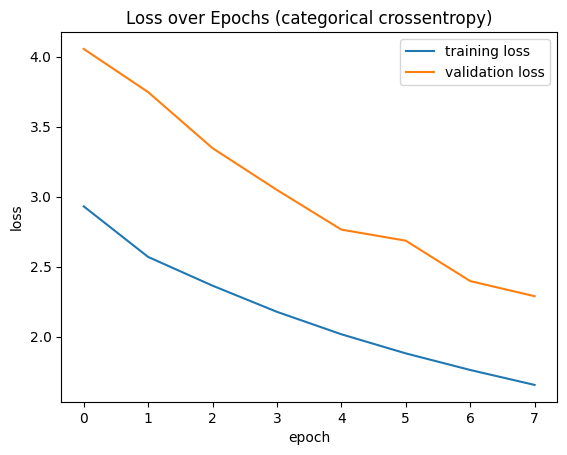

In [10]:
# model.save("policy network")

# plot the data
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

# label the axes
plt.xlabel("epoch")
plt.ylabel("loss")

plt.title("Loss over Epochs (categorical crossentropy)")
plt.legend(["training loss", "validation loss"])
plt.show()